In [39]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [40]:
medium_data = pd.read_csv('questions.csv')
medium_data['clean'] = medium_data['title']
medium_data.describe()

,title,clean
count,1000000,1000000
unique,949636,949636
top,Why?,Why?
freq,259,259


In [41]:
print("Number of records: ", medium_data.shape[0])
print("Number of fields: ", medium_data.shape[1])

Number of records:  1000000
Number of fields:  2


In [42]:
medium_data['title']

0          What's the ugliest word in the English language?
1         If you could bring one celebrity back from the...
2         The year is 2022. We've now discover how time ...
3                           What's your unpopular opinions?
4                         Celebrities with the biggest ego?
                                ...                        
999995    Is it true that, “If you don't use it, you los...
999996                 What is your favorite drive-through?
999997    (SERIOUS) WHAT'S A SFW WAY TO EXPLAIN THE AHEA...
999998    Will you see this post https://www.reddit.com/...
999999                What do you hope your last words are?
Name: title, Length: 1000000, dtype: object

In [43]:
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace('\u200a',' '))
medium_data['title'] = [x.lower() for x in medium_data['title']]

In [6]:
questions = medium_data['title'][:20000]
questions

0         what's the ugliest word in the english language?
1        if you could bring one celebrity back from the...
2        the year is 2022. we've now discover how time ...
3                          what's your unpopular opinions?
4                        celebrities with the biggest ego?
                               ...                        
19995    for the next 24 hours, anyone you want to have...
19996    why do some people who don't want kids still g...
19997    you go to a job interview and have a minute to...
19998          what's something that annoys you on reddit?
19999    which song makes you drive real fast that the ...
Name: title, Length: 20000, dtype: object

In [7]:

tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(questions)
total_words = len(tokenizer.word_index) + 1

# print("Total number of words: ", total_words)
# print("Word: ID")
# print("------------")
# print("<oov>: ", tokenizer.word_index['<oov>'])
# print("Strong: ", tokenizer.word_index['strong'])
# print("And: ", tokenizer.word_index['and'])
# print("Consumption: ", tokenizer.word_index['consumption'])

# Save the trained tokenizer
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
input_sequences = []
for line in questions:
    token_list = tokenizer.texts_to_sequences([line])[0]
    #print(token_list)
    
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# print(input_sequences)
print("Total input sequences: ", len(input_sequences))

Total input sequences:  262584


In [9]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,   18,    4,
       8385])

In [10]:
# create features and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [11]:
print(xs[5])
print(labels[5])
print(ys[5][14])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0   18    4 8385  218   12    4]
484
0.0


In [22]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(xs, ys, epochs=40, verbose=1)
#print model.summary()
print(model)

Epoch 1/40
8206/8206 [==============================] - 1833s 223ms/step - loss: 5.8464 - accuracy: 0.1441
Epoch 2/40
8206/8206 [==============================] - 1844s 225ms/step - loss: 5.0186 - accuracy: 0.2025
Epoch 3/40
8206/8206 [==============================] - 1816s 221ms/step - loss: 4.6040 - accuracy: 0.2306
Epoch 4/40
8206/8206 [==============================] - 1868s 228ms/step - loss: 4.2644 - accuracy: 0.2570
Epoch 5/40
8206/8206 [==============================] - 1790s 218ms/step - loss: 3.9707 - accuracy: 0.2820
Epoch 6/40
8206/8206 [==============================] - 1829s 223ms/step - loss: 3.7179 - accuracy: 0.3074
Epoch 7/40
8206/8206 [==============================] - 1995s 243ms/step - loss: 3.4938 - accuracy: 0.3324
Epoch 8/40
8206/8206 [==============================] - 2021s 246ms/step - loss: 3.2950 - accuracy: 0.3578
Epoch 9/40
8206/8206 [==============================] - 3066s 374ms/step - loss: 3.1177 - accuracy: 0.3815
Epoch 10/40
8206/8206 [==============

In [28]:
model.save("next_word_try_3_1.keras")

In [29]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

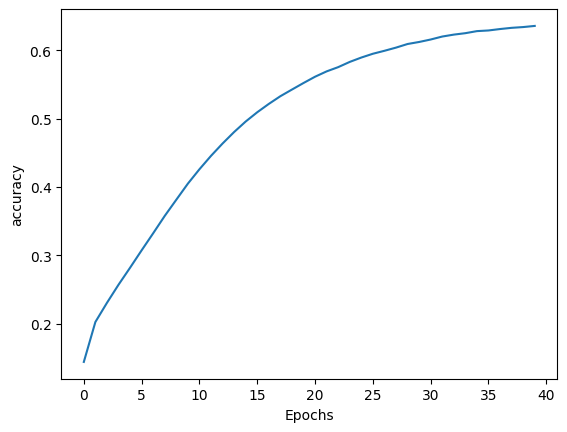

In [30]:
plot_graphs(history, 'accuracy')

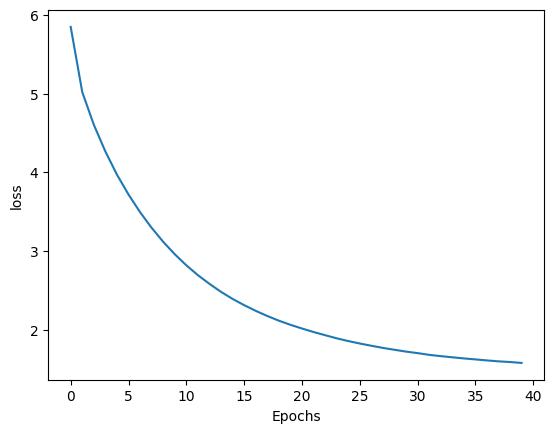

In [31]:
plot_graphs(history, 'loss')

In [33]:
model = keras.models.load_model("next_word_try_3_1.keras") 

In [18]:
seed_text = "let me ask you why"
next_words = 3
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
#     predicted = model.predict_classes(token_list, verbose=0)
    predicted=model.predict(token_list,verbose=0) 
    predicted=np.argmax(predicted,axis=1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

let me ask you why or why not


In [34]:
# predict only next word
def predict_next(seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
#     predicted = model.predict_classes(token_list, verbose=0)
    predicted=model.predict(token_list,verbose=0) 
    predicted=np.argmax(predicted,axis=1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
    return seed_text

In [25]:
list_input = ["will AI become", "why does it seem", "is it the right way to","Recipe of my","I am going to","will this work"]
list_out = []

for seed_text in list_input:
    list_out.append(predict_next(seed_text))

dict = {'Input':list_input,
        'Output':list_out}

df = pd.DataFrame(dict)
df

,Input,Output
0,will AI become,will AI become smarter
1,why does it seem,why does it seem to
2,is it the right way to,is it the right way to get
3,Recipe of my,Recipe of my own
4,I am going to,I am going to raise
5,will this work,will this work against


In [36]:
list_input = ["will AI become", "why does it seem", "is it the right way to","Recipe of my","I am going to","will this work"]
list_out = []

for seed_text in list_input:
    list_out.append(predict_next(seed_text))

dict = {'Input':list_input,
        'Output':list_out}

df = pd.DataFrame(dict)
df

,Input,Output
0,will AI become,will AI become a
1,why does it seem,why does it seem to
2,is it the right way to,is it the right way to be
3,Recipe of my,Recipe of my opinion
4,I am going to,I am going to be
5,will this work,will this work be


In [37]:
list_input = ["will AI become", "why does it seem", "is it the right way to","Recipe of my","I am going to","will this work","Am I on the right"]

predictions = [[],[],[]]

list_output = []

next_words = 1
for seed_text in list_input:
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

        # Predict probabilities for all words
        predicted_probabilities = model.predict(token_list, verbose=0)[0]

        # Get the indices of the top 3 predicted words
        top3_word_indices = np.argsort(predicted_probabilities)[-3:][::-1]

        # Get the top 3 words and their probabilities
        top3_words = [tokenizer.index_word[idx] for idx in top3_word_indices]
        top3_probabilities = [round(predicted_probabilities[idx],3) for idx in top3_word_indices]

        for i in range(len(top3_words)):
            o = str(top3_words[i])+" ("+str(top3_probabilities[i])+")"
            predictions[i].append(o)
                    
#         # Print the top 3 suggestions
#         print("Top 3 Predictions:")
#         for word, prob in zip(top3_words, top3_probabilities):
#             print(f"{word}: {prob:.4f}")

        # Choose the word with the highest probability as the next word
        output_word = top3_words[0]
        seed_text += " " + output_word
        list_output.append(seed_text)
        
        
dict = {'Input':list_input,
        'prediction 1':predictions[0],
        'prediction 2':predictions[1],
        'prediction 3':predictions[2],
        'Output':list_output,}    

df = pd.DataFrame(dict)
df

,Input,prediction 1,prediction 2,prediction 3,Output
0,will AI become,a (0.184),the (0.055),an (0.024),will AI become a
1,why does it seem,to (0.717),like (0.032),about (0.024),why does it seem to
2,is it the right way to,be (0.09),get (0.072),make (0.041),is it the right way to be
3,Recipe of my,opinion (0.028),own (0.027),life (0.018),Recipe of my opinion
4,I am going to,be (0.056),help (0.044),get (0.031),I am going to be
5,will this work,be (0.336),like (0.015),help (0.014),will this work be
6,Am I on the right,i (0.036),now (0.034),and (0.032),Am I on the right i


In [38]:
list_input = ["will AI become", "why does it seem", "is it the right way to","Recipe of my","I am going to","will this work","Am I on the right"]

predictions = [[],[],[]]

list_output = []

next_words = 1
for seed_text in list_input:
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

        # Predict probabilities for all words
        predicted_probabilities = model.predict(token_list, verbose=0)[0]

        # Get the indices of the top 3 predicted words
        top3_word_indices = np.argsort(predicted_probabilities)[-3:][::-1]

        # Get the top 3 words and their probabilities
        top3_words = [tokenizer.index_word[idx] for idx in top3_word_indices]
        top3_probabilities = [round(predicted_probabilities[idx],3) for idx in top3_word_indices]

        for i in range(len(top3_words)):
            o = str(top3_words[i])+" ("+str(top3_probabilities[i])+")"
            predictions[i].append(o)
                    
#         # Print the top 3 suggestions
#         print("Top 3 Predictions:")
#         for word, prob in zip(top3_words, top3_probabilities):
#             print(f"{word}: {prob:.4f}")

        # Choose the word with the highest probability as the next word
        output_word = top3_words[0]
        seed_text += " " + output_word
        list_output.append(seed_text)
        
        
dict = {'Input':list_input,
        'prediction 1':predictions[0],
        'prediction 2':predictions[1],
        'prediction 3':predictions[2],
        'Output':list_output,}    

df = pd.DataFrame(dict)
df

,Input,prediction 1,prediction 2,prediction 3,Output
0,will AI become,a (0.184),the (0.055),an (0.024),will AI become a
1,why does it seem,to (0.717),like (0.032),about (0.024),why does it seem to
2,is it the right way to,be (0.09),get (0.072),make (0.041),is it the right way to be
3,Recipe of my,opinion (0.028),own (0.027),life (0.018),Recipe of my opinion
4,I am going to,be (0.056),help (0.044),get (0.031),I am going to be
5,will this work,be (0.336),like (0.015),help (0.014),will this work be
6,Am I on the right,i (0.036),now (0.034),and (0.032),Am I on the right i


In [3]:
# saving the tokenizer
import pandas as pd
import numpy as np
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer

medium_data = pd.read_csv('questions.csv')
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace('\u200a',' '))

tokenizer = Tokenizer(oov_token='<oov>')  # For those words which are not found in word_index
tokenizer.fit_on_texts(medium_data['title'])

# Save the trained tokenizer
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)